#### Script to map snapshots from WRF output for Ida (2021).

James Ruppert  
jruppert@ou.edu  
11/16/23

In [13]:
from netCDF4 import Dataset
import numpy as np
from matplotlib import ticker, colors, rc#, cm
import matplotlib.pyplot as plt
# from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
#                  cartopy_ylim, latlon_coords)
from wrf import to_np, getvar, get_cartopy, interplevel, smooth2d
import cartopy.crs as crs
import cartopy.feature as cfeature
from metpy.plots import ctables
import subprocess

#### Main Settings

In [14]:
# Function to account for crossing of the Intl Date Line
def dateline_lon_shift(lon_in, reverse):
    if reverse == 0:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in < 0)] += 360
    else:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in > 180)] -= 360
    # return lon_in + lon_offset
    return lon_offset

In [15]:
#### Directories and model output specs
# datdir = "/glade/derecho/scratch/ruppert/temp/run/"
# datdir = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tctor/"
datdir = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/"
figdir = "/home/jamesrup/python/jhr-wrf-python/"
process = subprocess.Popen(['ls '+datdir+'wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readlines()
nt = len(output)

#### Directories and model output specs
def get_dims_files(wrf_domain):
    # datdir = "/glade/derecho/scratch/ruppert/temp/run/"
    # datdir = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tctor/"
    process = subprocess.Popen(['ls '+datdir+'wrfout_'+wrf_domain+'_*'],shell=True,
        stdout=subprocess.PIPE,universal_newlines=True)
    output = process.stdout.readlines()
    nt = len(output)
    wrffil_read = Dataset(output[0].strip())
    lat = wrffil_read.variables['XLAT'][:][0] # deg
    lon = wrffil_read.variables['XLONG'][:][0] # deg
    lat1d = lat[:,0]
    lon1d = lon[0,:]
    nx1 = lat1d.size
    nx2 = lon1d.size
    nz = wrffil_read.dimensions['bottom_top'].size
    pres = wrffil_read.variables['PB'][0,:,0,0]*1e-2 # Pa --> hPa
    wrffil_read.close()
    return output, lat1d, lon1d, nz, pres
output, lat, lon, nz, pres = get_dims_files("d02")

In [16]:
# Check for crossing Date Line
if (lon.min() < 0) and (lon.max() > 0):
    offset = 180
    lon_offset = dateline_lon_shift(lon, reverse=0)
else:
    offset = 0
    lon_offset = 0
    clon_offset = 0

lon_offset_plt = lon + lon_offset
lon_offset_plt -= offset

In [17]:
# Pick example time steps for landfall and secondary TC-Tor period
time1 = 72
time2 = 144

---
### Plotting routines

In [18]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

rc('font', **font)

##### Plotting functions

In [19]:
# wind barbs
def plot_wind(ax, u, v, lon, lat, skip, transform, length=None):
    spacing=skip #barbspacing (smaller if zoomed in)
    mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
    uplt = u * mps_to_kts
    vplt = v * mps_to_kts
    ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], 
             uplt[::spacing,::spacing], vplt[::spacing,::spacing], 
             zorder=2, color='black', length=length,
             transform=crs.PlateCarree(), linewidth=1.5)

In [20]:
# Variable settings

def figure_var_specs(plot_name):

    # Switches (default settings)
    i2d=True      # switch on if the data read-in needs to be done in 2D
    dosym=True    # switch off to specify min colorbar setting
    dolog=False   # switch for logarithmic color scale
    extend='both' # extend color fill beyond bounds
    scale=1.      # scale variable by x
    vartag=plot_name

    if plot_name == 'OLR':
        # OLR
        unittag='W m$^{-2}$'
        cmin=75
        cmax=320
        dosym=False
        cmap='RdGy'
    elif plot_name == 'MRef':
        # Base reflectivity
        vartag='mdbz'
        unittag='dBZ'
        cmin=-25
        cmax=60
        dosym=False
        extend='neither'
        # cmap = ctables.registry.get_colortable('NWSReflectivity')#'NWSReflectivityExpanded'
        cmap='Spectral_r'
    elif plot_name == 'UpHelic':
        # Updraft helicity
        vartag='updraft_helicity'
        unittag='m$^2$ s$^{-2}$'
        cmin=10
        cmax=70
        dosym=False
        extend='neither'
        cmap='Spectral_r'
    elif plot_name == '2mTemp':
        # 2m Temperature
        vartag='T2'
        unittag='K'
        cmin=280
        cmax=310
        dosym=False
        extend='both'
        cmap='RdBu_r'
    elif plot_name == '900-600Thick':
        # p-layer thickness
        unittag='dam'
        cmin=330
        cmax=343
        dosym=False
        extend='both'
        cmap='RdBu_r'

    return vartag, unittag, cmin, cmax, extend, cmap, i2d, dosym, dolog, scale

In [23]:
def run_plot(plot_name, plt_area, wrf_domain, it_read):

    vartag, unittag, cmin, cmax, extend, cmap, i2d, dosym, dolog, scale = figure_var_specs(plot_name)

    wrffiles, lat, lon, nz, pres = get_dims_files(wrf_domain)
    # plt_area=[lon[0,0], 360-lon[0,-1], lat[0,0], lat[-1,-1]] # W,E,S,N
    # plt_area=[lon[0,0], 154, 0,5] # W,E,S,N
    plt_area=[155, 165, -2, 10]

    title_extra=''
    if plot_name == 'UpHelic' or plot_name == '900-600Thick':
        accum=12
        title_extra=' ('+str(accum)+'hr accum)'
        for iread in range(accum):
            wrffil_read = Dataset(wrffiles[it_read-iread].strip())
            if iread == 0:
                pltvar = getvar(wrffil_read, 'updraft_helicity')
                time = to_np(getvar(wrffil_read, 'Times'))
            else:
                pltvar += getvar(wrffil_read, 'updraft_helicity')
            wrffil_read.close()
        uphel=pltvar

    wrffil_read = Dataset(wrffiles[it_read].strip())
    time = to_np(getvar(wrffil_read, 'Times'))
    if plot_name == '900-600Thick':
        z = getvar(wrffil_read, "z", units="dm")
        p = getvar(wrffil_read, "pres", units="hPa")
        ht_up = interplevel(z, p, 600)
        ht_low = interplevel(z, p, 900)
        thick = ht_up - ht_low
        # pltvar = thick
        pltvar = smooth2d(thick, 6, cenweight=2)
    elif plot_name != 'UpHelic':
        pltvar = getvar(wrffil_read, vartag)
    wrffil_read.close()

    if plot_name == "2mTemp" or plot_name == 'UpHelic' or plot_name == '900-600Thick':
        wrffil_read = Dataset(wrffiles[it_read].strip())
        u10 = to_np(getvar(wrffil_read, "U10")) # m/s
        v10 = to_np(getvar(wrffil_read, "V10")) # m/s
        wrffil_read.close()

    hr_tag = str(time)[0:16]

    # Add thickness contours to UpHelic maps
    if plot_name == 'UpHelic':
        wrffil_read = Dataset(wrffiles[it_read].strip())
        z = getvar(wrffil_read, "z", units="dm")
        p = getvar(wrffil_read, "pres", units="hPa")
        ht_up = interplevel(z, p, 600)
        ht_low = interplevel(z, p, 900)
        thick = ht_up - ht_low
        cont_var = smooth2d(thick, 6, cenweight=2)
        wrffil_read.close()

    if i2d:
        title = plot_name+title_extra+', '+hr_tag
    else:
        title = plot_name+title_extra+', '+hr_tag+',  k-level='+str(ikread)+' (p = '+str(int(pres[ikread]))+' hPa)'

    # Color scale
    nlevs=31#71
    if dosym:
        delta=2*cmax/nlevs
        clevs = np.arange(-1*cmax,cmax+delta,delta)
    else:
        delta=(cmax-cmin)/nlevs
        clevs = np.arange(cmin,cmax+delta,delta)

    # create figure
    # do_plot(pltvar, title, clevs, cmap, lon_offset_plt, lat, unittag, plt_area)

    fig = plt.figure(figsize=(18,10))
    # proj = cartopy.crs.PlateCarree(central_longitude=np.mean(lon1d))
    # proj = crs.PlateCarree(central_longitude=offset)
    if plot_name == '900-600Thick':
        proj = get_cartopy(z)
    else:
        proj = get_cartopy(pltvar)
    ax = fig.add_subplot(111,projection=proj)
    ax.set_title(title, fontsize=20)

    # Set plot area
    ax.set_extent(plt_area)

    # fill contour
    if dolog:
        im = ax.contourf(lon, lat, to_np(pltvar)*scale, cmap=cmap, alpha=0.9,
                            extend='both', zorder=0, norm=colors.LogNorm(vmin=cmin, vmax=cmax),
                            transform=crs.PlateCarree(central_longitude=offset))
        ticks=ticker.LogLocator()
    #     im = ax.contourf(lon, lat, to_np(pltvar), clevs, cmap=cmap, alpha=0.9,
    #                         # extend='both', 
    #                         zorder=0, norm=colors.Normalize(cmin, cmax),
    #                         transform=crs.PlateCarree())
    #     ticks=ticker.AutoLocator()
    else:
        im = ax.contourf(lon, lat, to_np(pltvar)*scale, clevs, cmap=cmap, alpha=0.9,
                            extend=extend, zorder=0, transform=crs.PlateCarree(central_longitude=offset))
        ticks=ticker.AutoLocator()

    cbar = plt.colorbar(im, ax=ax, shrink=0.45, ticks=ticks)
    cbar.ax.set_ylabel(unittag)

    # Overlay contours of thickness on Updraft Helicity plot
    if plot_name == "UpHelic":
        cont_levs = np.arange(300,400,1)
        im = ax.contour(lon, lat, to_np(cont_var)*scale, cont_levs, colors='k', 
                            transform=crs.PlateCarree())
        ax.clabel(im)

    # Overly updraft helicity shading on Thickness plot
    if plot_name == "900-600Thick":
        cmin=5; cmax=6
        delta=(cmax-cmin)/nlevs
        clevs2 = np.arange(cmin,cmax+delta,delta)
        im = ax.contourf(lon, lat, to_np(uphel)*scale, clevs2, cmap='Greys', alpha=0.5,
                            extend='max', zorder=0, transform=crs.PlateCarree())
        # ticks2=ticker.AutoLocator()
        # cbar2 = plt.colorbar(im, ax=ax, shrink=0.45, ticks=ticks2)
        # cbar2.ax.set_ylabel('m$^2$ s$^{-2}$')

    # Add wind barbs
    if plot_name == "2mTemp" or plot_name == 'UpHelic' or plot_name == '900-600Thick':
        skip = int(u10.shape[0]/30)
        plot_wind(ax, u10, v10, lon, lat, skip, crs.PlateCarree(central_longitude=offset), length=6)

    # Add map features
    states = cfeature.NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_lines")
    countries = cfeature.NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_0_countries_lakes")
    featurewidth=0.5
    featurecol="black"
    ax.add_feature(states, linewidth=featurewidth, edgecolor=featurecol, zorder=1)
    ax.add_feature(countries, linewidth=featurewidth, edgecolor=featurecol, zorder=1)
    # ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # plt.savefig(figdir+plot_name+"_"+hr_tag[0:-3]+".pdf", format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()

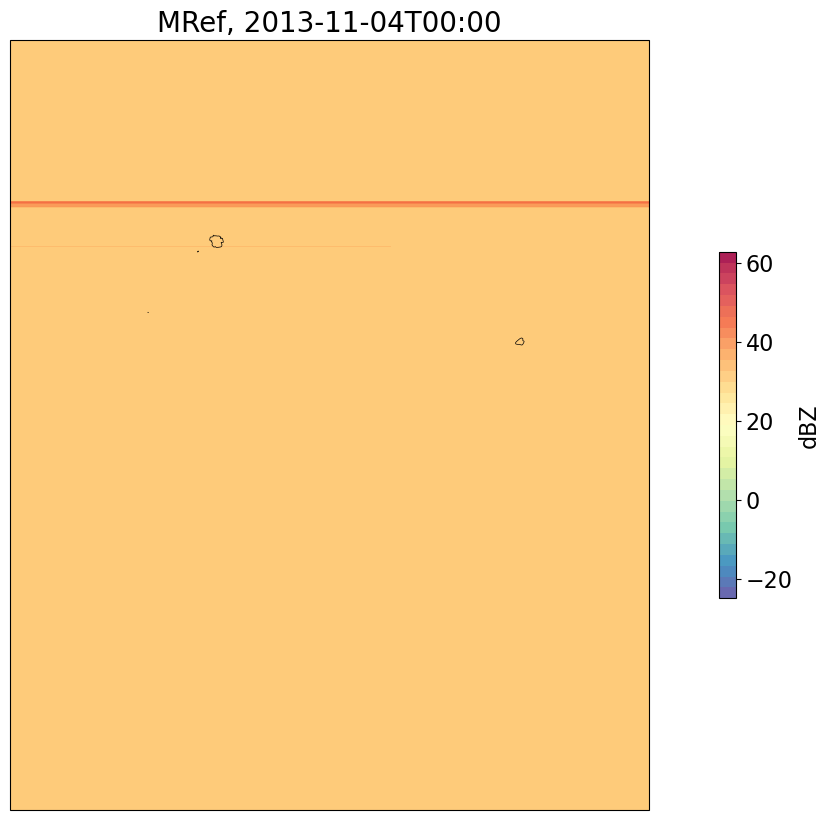

In [24]:
# 1000-500 THICKNESS ONLY IN THIS BOX
# Plot setup

# wrf_domain="d01"
wrf_domain="d02"

# plt_area=[lon1d[0], lon1d[-1], lat1d[0], lat1d[-1]] # W,E,S,N
def get_plt_area(phase):
    if phase == "landfall":
        plt_area=[-96, -78, 26, 36] # W,E,S,N
        # Time specs
        tstep_start=48
        time_interval=12
        tstep_end = 3*24+1
    elif phase == "postET":
        plt_area=[-91, -73, 33, 43] # W,E,S,N
        # Time specs
        tstep_start=72
        time_interval=12
        tstep_end = 4*24+13
    tstep_end -= np.max([0, tstep_start+tstep_end - nt])
    time_range = range(tstep_start,tstep_start+tstep_end, time_interval)
    return plt_area, time_range

# allvars=["2mTemp", "OLR", "MRef", "UpHelic", "900-600Thick"]:

it = time1
phase = "landfall"
plt_area, time_range = get_plt_area(phase)
# for var_name in ["OLR", "MRef", "UpHelic", "900-600Thick"]:
# for var_name in ["OLR", "MRef", "900-600Thick"]:
plt_area=[144.02167, -178.61954, -2.5528107, 20.050117]
for var_name in ["MRef"]:
    run_plot(var_name, plt_area, wrf_domain, it)

# it = time2
# phase = "postET"
# plt_area, time_range = get_plt_area(phase)
# # for var_name in ["OLR", "MRef", "UpHelic", "900-600Thick"]:
# for var_name in ["OLR", "MRef", "900-600Thick"]:
# # for var_name in ["900-600Thick"]:
#     run_plot(var_name, plt_area, wrf_domain, it)

# phase_arr = ["landfall", "postET"]

# for phase in phase_arr:

#     plt_area, time_range = get_plt_area(phase)

#     for it in time_range:

#         # Just run first time step
#         # if it > time_range[0]: continue

#         for var_name in ["2mTemp", "OLR", "MRef", "UpHelic"]:

#             run_plot(var_name, plt_area, wrf_domain, it)